# Collecting crypto currency data

In [1]:
!git clone https://github.com/sinker048/crypto.git

Cloning into 'crypto'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 10 (delta 2), reused 10 (delta 2), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [2]:
cd crypto

/content/crypto


In [3]:
!pip install python-binance
!pip install Backtesting
!pip install backtrader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 10.6 MB/s 
     |████████████████████████████████| 112 kB 65.8 MB/s 
     |████████████████████████████████| 288 kB 48.5 MB/s 
     |████████████████████████████████| 45 kB 4.3 MB/s 
     |████████████████████████████████| 144 kB 62.6 MB/s 
     |████████████████████████████████| 271 kB 68.7 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 4.9 MB/s 
  Created wheel for Backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173822 sha256=5f582821c2e02a55c9feb5817ae766aef8c1dbcb3b566e2e06eb9ca261ac534c
  Stored in directory: /root/.cache/pip/wheels/48/1d/ea/65dacebc37da7655d8a1fd0f315ac39d102e31d6545237a1c6
Successfully built 

Crawling ETH data

In [4]:
from crawling import *
df = get_all_binance('ETHUSDT', '1d',True)
df.head()

All caught up....!


,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2017-08-17,301.13,312.18,298.00,302.00,7030.71034,1503014399999,2154655.30035660,4522,6224.58999000,1908705.36853020,50579.87228839
2017-08-18,302.00,311.79,283.94,293.96,9537.84646,1503100799999,2858946.50935390,5658,7452.43542000,2240813.26122640,55329.57432378
2017-08-19,293.31,299.90,278.00,290.91,2146.19773,1503187199999,620022.58986170,1795,1537.97550000,444713.61220860,58005.17104565
2017-08-20,289.41,300.53,282.85,299.10,2510.13871,1503273599999,742847.89455990,2038,2186.68739000,647506.06202050,60299.06615403
2017-08-21,299.10,346.52,294.60,323.29,5219.44542,1503359999999,1689472.34121400,3925,4004.19967000,1297977.42311420,66203.84022245


In [5]:
data = df.reset_index()


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import torch
import torch.nn as nn
import math
import time

# Transformer


In [7]:
input_window = 10
output_window = 1
batch_size = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

close = np.array(data['close'])
logreturn = np.diff(np.log(close))

csum_logreturn = logreturn.cumsum()

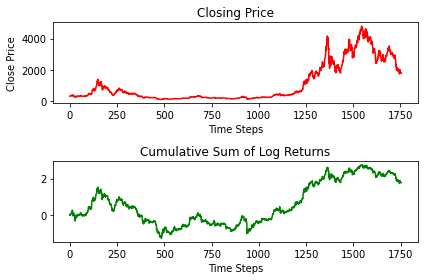

In [8]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(close, color='red')
axs[0].set_title('Closing Price')
axs[0].set_ylabel('Close Price')
axs[0].set_xlabel('Time Steps')

axs[1].plot(csum_logreturn, color='green')
axs[1].set_title('Cumulative Sum of Log Returns')
axs[1].set_xlabel('Time Steps')

fig.tight_layout()
plt.show()

Positional Encoder

In [9]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, max_len = 5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
      
    def forward(self, x):
        return x + self.pe[:x.size(0), :]

Transformer model

In [10]:
class TransAm(nn.Module):
    def __init__(self, feature_size = 50, num_layers = 1, dropout = 0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model = feature_size, nhead = 10, dropout = dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

Window function, split data into sequence window

In [11]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq, train_label))
    return torch.FloatTensor(inout_seq)

Split data in training and testing, prepared in windowed sequences and pass through GPU

In [12]:
def get_data(data, split):
    '''split ratio of training data'''
    series = data

    split = round(split * len(series))
    train_data = series[:split]
    test_data = series[split:]

    train_data = train_data.cumsum()
    train_data = 2 * train_data # training data augmentation, increase amplitude for the model to better generalize

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data, input_window)
    train_sequence = train_sequence[:-output_window]

    test_data = create_inout_sequences(test_data, input_window)
    test_data = test_data[:-output_window]

    return train_sequence.to(device), test_data.to(device)

Split into training batches

In [13]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return input, target

Training function

In [14]:
def train(train_data):
    model.train() # Turn on the evaluation mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size /5 )
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:5.2f} ms | '
                  'loss {:5.7f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

Evaluation function for model after training

In [15]:
def evaluate(eval_model, data_source):
    eval_model.eval()
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            total_loss += len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

Function to forecast 1 time step from window sequence



In [16]:
def model_forecast(model, sequence):
    model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)

    seq = np.pad(sequence, (0, 3), mode = 'constant', constant_values=(0, 0))
    seq = create_inout_sequences(seq, input_window)
    seq = seq[:-output_window].to(device)

    seq, _ = get_batch(seq, 0, 1)
    with torch.no_grad():
        for i in range(0, output_window):
            output = model(seq[-output_window:])
            seq = torch.cat((seq, output[-1:]))
    
    seq = seq.cpu().view(-1).numpy()
    return seq

Function to forecast entire sequence

In [17]:
def forecast_seq(model, sequences):
    start_timer = time.time()
    model.eval()
    forecast_seq = torch.Tensor(0)
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1).cpu()), 0)
            actual = torch.cat((actual, target[-1].view(-1).cpu()), 0)
    
    timed = time.time() - start_timer
    print(f'{timed} sec')

    return forecast_seq, actual

Prepare data for training model

In [18]:
train_data, val_data = get_data(logreturn, 0.8)
model = TransAm().to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  


Model parameters

In [19]:
criterion = nn.MSELoss()
lr = 0.00005

optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

epochs = 150

Train loop

In [20]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)

    if (epoch % epochs == 0):
        val_loss = evaluate(model, val_data)
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid_loss: {:5.7f}'.format(epoch, (time.time() - epoch_start_time), val_loss))
        print('-' * 80)
    
    else:
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 80)
    
    scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:372: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |     5/   27 batches | lr 0.0000500000 | 38.64 ms | loss 2.5493187
| epoch   1 |    10/   27 batches | lr 0.0000500000 |  4.47 ms | loss 2.0962986
| epoch   1 |    15/   27 batches | lr 0.0000500000 |  4.58 ms | loss 1.2657651
| epoch   1 |    20/   27 batches | lr 0.0000500000 |  7.02 ms | loss 1.0387136
| epoch   1 |    25/   27 batches | lr 0.0000500000 |  4.51 ms | loss 2.6249808
--------------------------------------------------------------------------------
| end of epoch   1 | time:  0.31s
--------------------------------------------------------------------------------
| epoch   2 |     5/   27 batches | lr 0.0000451250 |  5.35 ms | loss 1.2924832
| epoch   2 |    10/   27 batches | lr 0.0000451250 |  4.55 ms | loss 0.5643792
| epoch   2 |    15/   27 batches | lr 0.0000451250 |  4.52 ms | loss 0.2352951
| epoch   2 |    20/   27 batches | lr 0.0000451250 |  5.88 ms | loss 0.1699928
| epoch   2 |    25/   27 batches | lr 0.0000451250 |  5.53 ms | loss 1.4427567
----

In [21]:
test_result, truth = forecast_seq(model, val_data)


0.27679443359375 sec


Plot forecasted sequence vs actual

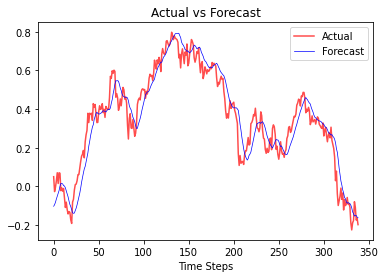

In [22]:
plt.plot((truth), color='red', alpha=0.7)
plt.plot((test_result), color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()